<a href="https://colab.research.google.com/github/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/blob/main/notebooks/Exploring_VGG16_EfficientNetB5_EfficientNetB4_for_Human_Emotion_Detection_with_Grad_CAM_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring EfficientNetB5 for Human Emotion Detection with Grad-CAM Visualization

## Introduction  
This notebook focuses on two key objectives for human emotion detection using deep learning:  
1. Visualizing intermediate layers of the VGG16 network to understand how it processes features at different depths.  
2. Training EfficientNetB5 and leveraging its trained weights to implement the Grad-CAM (Gradient-weighted Class Activation Mapping) method for interpretability.  

By combining intermediate layer visualizations and Grad-CAM, we aim to gain insights into the model's decision-making process and validate its predictions. The approach enhances trust in AI systems by making the outcomes more interpretable and explainable.  

---

## Overview of the Grad-CAM Method  

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique that enhances the interpretability of deep learning models, particularly convolutional neural networks (CNNs). It highlights the regions in an input image that are most influential in the model's prediction, enabling us to understand its decision-making process.

### Key Concepts  
1. **Feature Maps**:  
   CNNs extract hierarchical features from input images, with each convolutional layer producing feature maps. Grad-CAM focuses on the final convolutional layers because they capture high-level patterns that are relevant to the classification task.  

2. **Gradients**:  
   Gradients are calculated to measure the sensitivity of the model's prediction with respect to the feature maps of the last convolutional layer. These gradients indicate how much the model's output changes when a specific feature is emphasized.  

3. **Class Discrimination**:  
   Grad-CAM is class-specific. For a given class (e.g., "happy" emotion), it computes gradients that explain the importance of each spatial region of the feature map for predicting that class.  

4. **Weighted Feature Maps**:  
   The method uses the computed gradients to assign weights to the feature maps. Regions with higher weights contribute more to the prediction for the specified class.  

5. **Heatmap Generation**:  
   The weighted feature maps are combined to create a heatmap, which highlights the most important regions of the input image. This heatmap is then overlaid on the original image for visualization.

### Steps in Grad-CAM  
1. **Forward Pass**:  
   The input image is passed through the CNN to obtain predictions.  

2. **Gradient Calculation**:  
   Gradients of the predicted class score are calculated with respect to the output of the last convolutional layer.  

3. **Weight Computation**:  
   The gradients are global-average-pooled to generate a set of weights corresponding to each feature map.  

4. **Feature Map Combination**:  
   The weights are used to compute a weighted sum of the feature maps, producing a class-specific heatmap.  

5. **Visualization**:  
   The heatmap is resized to match the dimensions of the input image and overlaid using color gradients to indicate the importance of each region.

### Applications  
Grad-CAM is widely used in tasks requiring model interpretability, including:  
- **Medical Imaging**: Highlighting regions critical for diagnosing diseases.  
- **Object Recognition**: Understanding which parts of an image contribute to object detection or classification.  
- **Emotion Detection**: Identifying facial regions or features driving emotion classification.  

### Advantages and Limitations  
**Advantages**:  
- Class-specific and highlights relevant image regions.  
- Works with a variety of CNN-based models.  
- Does not require modification to the original architecture.

**Limitations**:  
- Relies on the interpretability of convolutional feature maps, which may not always align with human intuition.  
- May lose resolution due to reliance on coarse feature maps from deeper layers.

Grad-CAM is a powerful tool that combines explainability and flexibility, making it an essential technique for visualizing and interpreting CNN-based models.


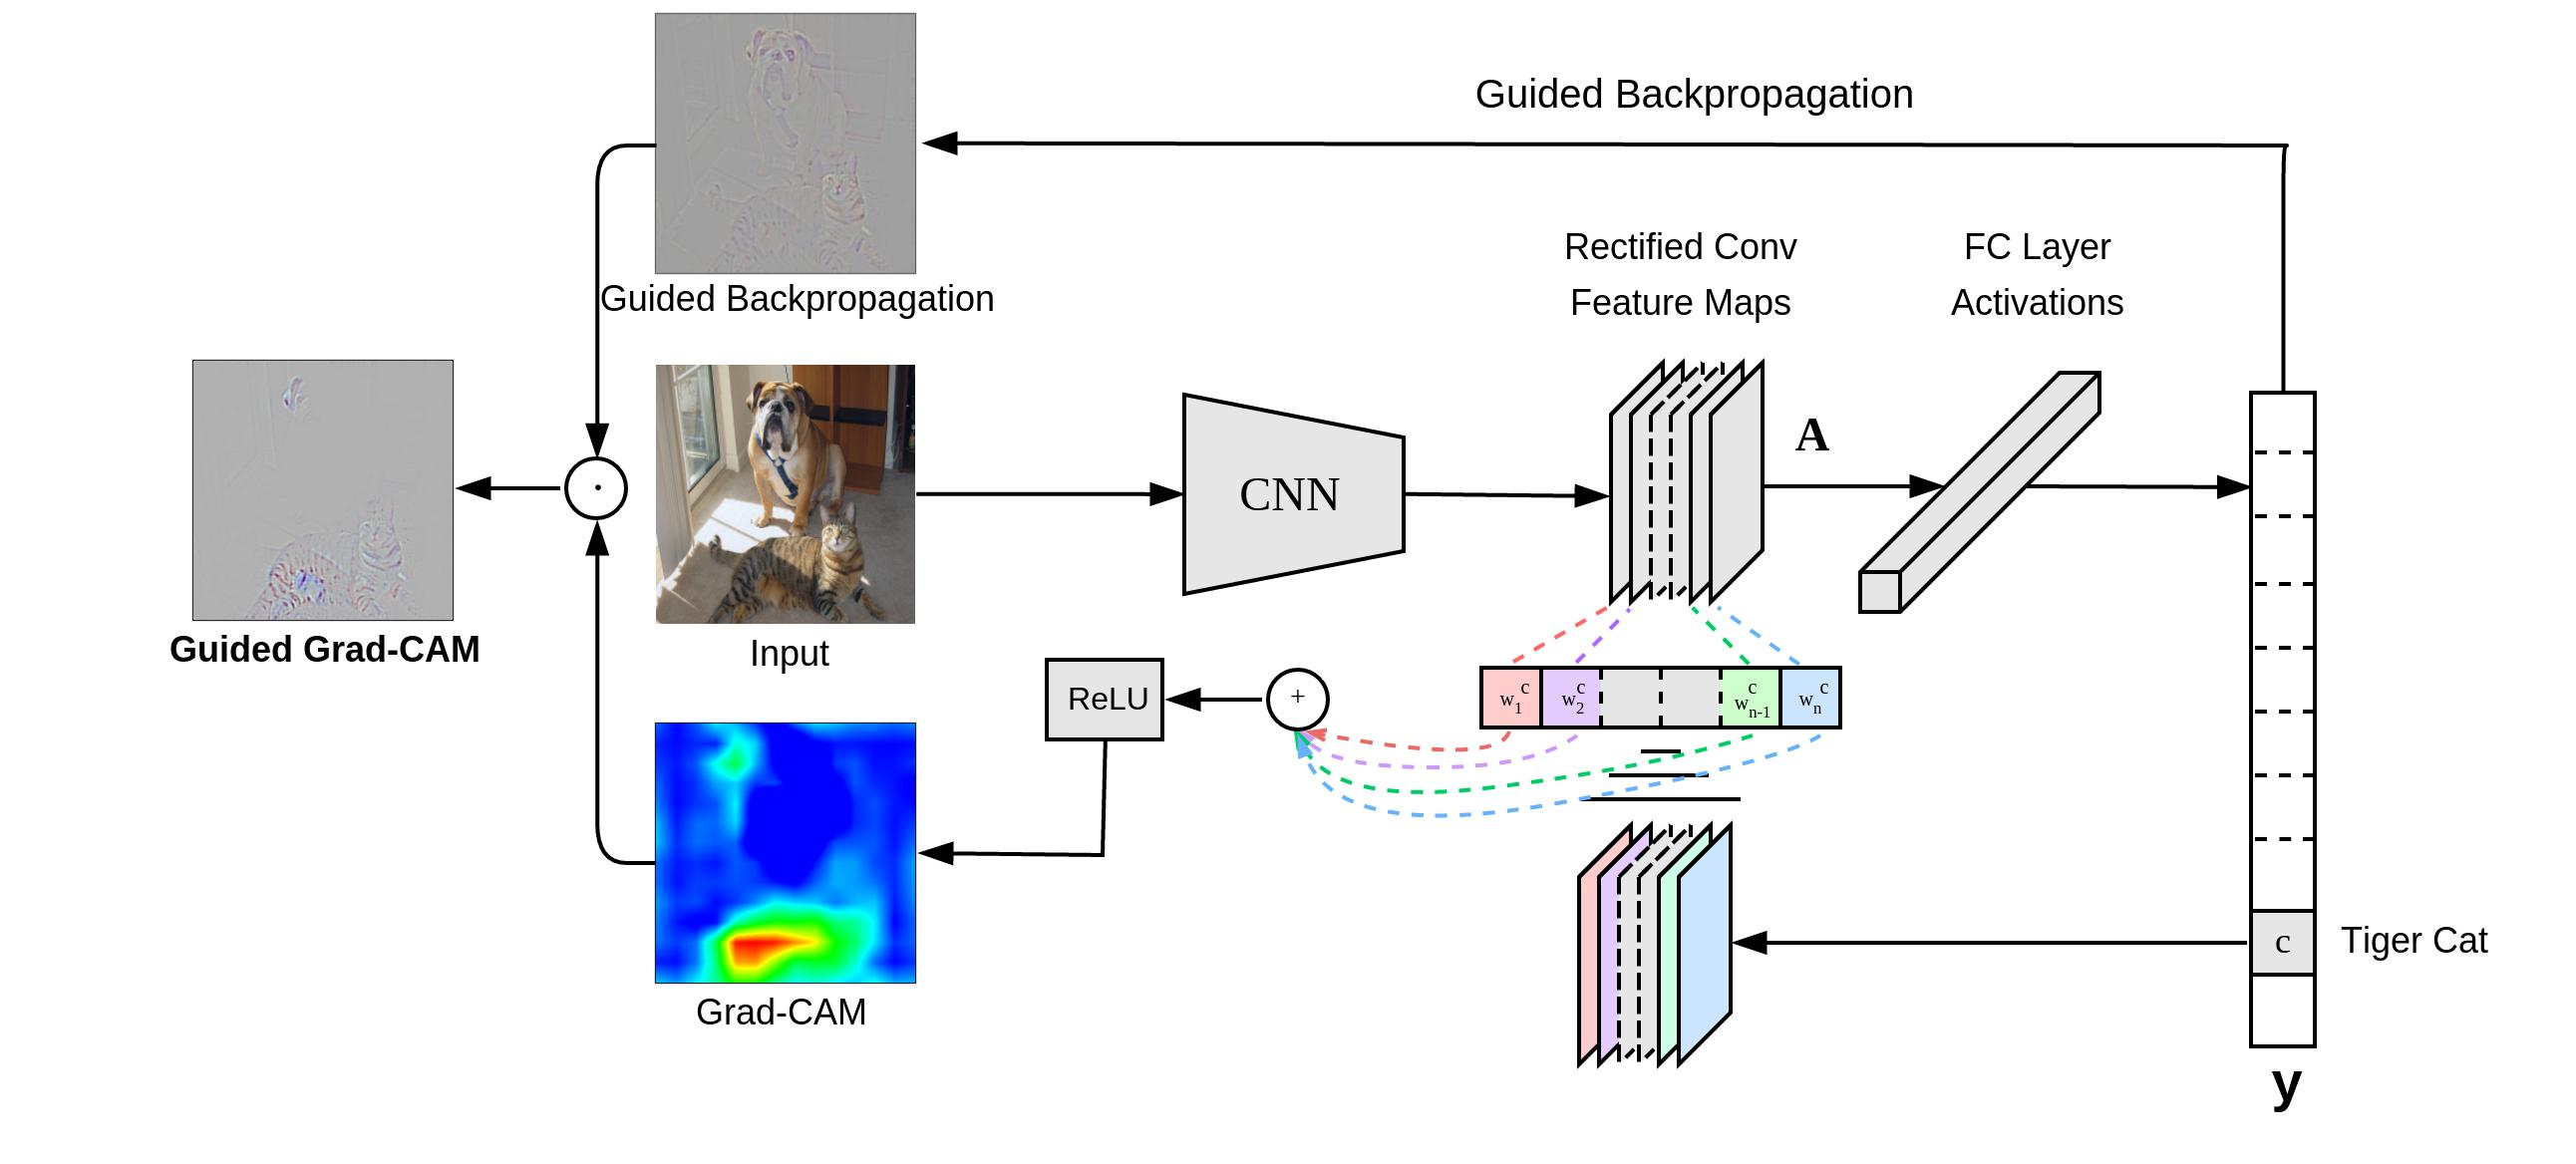

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600/root/.kaggle/kaggle.json

chmod: missing operand after ‘600/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:02<00:00, 152MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [ ]:
!mv /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4 /content/


In [ ]:
train_directory = "/content/4/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/4/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry" , "happy" , "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
training_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Using VGG16 Backbone for Feature Map Extraction  

#### 1. **Loading the Pre-trained VGG16 Model**  
The `VGG16` model is loaded using TensorFlow/Keras with the following configurations:  
- **`include_top=False`**: Excludes the fully connected (top) layers of the model. This allows the model to act as a feature extractor, focusing on convolutional layers for extracting intermediate features.  
- **`weights="imagenet"`**: Utilizes pre-trained weights from ImageNet, which provides a strong starting point by leveraging learned representations from a large dataset.  
- **`input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)`**: Specifies the input image dimensions, ensuring compatibility with the dataset used.  

By excluding the top layers, the model outputs feature maps instead of final classifications, enabling analysis of intermediate layers.

#### 2. **Displaying the Model Architecture**  
The `vgg_backbone.summary()` function prints a detailed summary of the VGG16 architecture, including the layers, their types, output shapes, and the number of parameters. This is useful for understanding the structure and identifying specific layers for visualization or fine-tuning.

---

#### 3. **Filtering Convolutional Layers**  
The `is_conv` function determines whether a layer is a convolutional layer based on its name:  
- If the layer's name contains the string `'conv'`, it is identified as a convolutional layer and selected for further processing.  
- Non-convolutional layers, such as pooling layers, are ignored to focus solely on the feature maps produced by convolutional layers.  

---

#### 4. **Extracting Feature Maps**  
The list comprehension `[layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]` is used to extract the output of all convolutional layers in the `vgg_backbone`. Key points:  
- **`vgg_backbone.layers[1:]`**: Iterates through all layers except the input layer.  
- **`if is_conv(layer.name)`**: Ensures only convolutional layers are selected.  
- **`layer.output`**: Captures the feature maps produced by each convolutional layer.

These feature maps represent the intermediate representations learned by the model at various depths, highlighting how the network processes the input image hierarchically.

---

#### 5. **Creating a Model for Feature Map Extraction**  
A new Keras model, `feature_maps_model`, is defined with the following:  
- **Inputs**: The same input as the `vgg_backbone`.  
- **Outputs**: The feature maps from all selected convolutional layers.  

This model enables efficient extraction of intermediate features by taking an image input and returning the corresponding feature maps from all convolutional layers. It serves as a powerful tool for visualizing and understanding the learning process of VGG16.

By setting up this architecture, the notebook is prepared to analyze and interpret the hierarchical feature extraction capabilities of the VGG16 backbone.


In [ ]:
vgg_backbone =tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape= (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3),
    # Since we are not gonna to take the top :
    # pooling=None,
    # classes=1000,
    # classifier_activation="softmax",
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
vgg_backbone.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_maps_model = Model(inputs=vgg_backbone.input, outputs=feature_maps)

In [ ]:
feature_maps_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Visualizing Feature Maps for a Test Image  

#### 1. **Loading and Preprocessing a Test Image**  
The test image is loaded and prepared for feature map extraction using the following steps:  
- **`cv2.imread`**: Reads the test image from the specified path.  
- **`cv2.resize`**: Resizes the image to match the input dimensions required by the model (`CONFIGURATION["IM_SIZE"] x CONFIGURATION["IM_SIZE"]`). This ensures compatibility with the VGG16 backbone.  
- **`tf.constant`**: Converts the image into a TensorFlow constant of data type `tf.float32` for model compatibility.  
- **`tf.expand_dims`**: Adds an extra batch dimension to the image tensor (`axis=0`), as the model expects a batch of images.  

These steps prepare the test image for feature extraction by the model.

---

#### 2. **Extracting Feature Maps**  
- The preprocessed image is passed through the `feature_maps_model` using `predict(im)`.  
- The model outputs a list of feature maps, where each map corresponds to the output of a specific convolutional layer.  
- The variable `f_maps` holds these feature maps, enabling further analysis and visualization.

---

#### 3. **Inspecting Feature Map Shapes**  
The shapes of all extracted feature maps are printed in a loop:  
- **`f_maps[i].shape`**: Outputs the dimensions of the feature map at layer `i`.  
- This step provides an overview of how the spatial dimensions and the number of channels change across layers, reflecting the network's hierarchical processing.

---

#### 4. **Visualizing Feature Maps**  
The feature maps are visualized in a loop to understand how the model processes and extracts features:  
- **Figure Setup**: A large figure (`figsize=(256,256)`) is initialized for visualizing all feature maps from a layer.  
- **Dimensions and Channels**:  
  - `f_size`: The spatial dimensions (height and width) of the feature map.  
  - `n_channels`: The number of channels in the feature map, representing distinct feature detectors.  
- **Joint Map Initialization**:  
  - A `joint_map` matrix of size `(f_size, f_size * n_channels)` is created.  
  - This matrix concatenates all channels of the feature map horizontally for visualization.  
- **Filling the Joint Map**:  
  - Each channel's 2D feature map is placed in its respective position in `joint_map`.  

#### 5. **Displaying the Joint Map**  
- **`plt.imshow`**: Displays a portion of the `joint_map`, focusing on the first 512 pixels in width for better visualization.  
- **`plt.axis("off")`**: Removes axis ticks and labels for cleaner visualizations.

By visualizing the feature maps, we gain insights into how the network processes the image at each layer. Early layers capture low-level features like edges and textures, while deeper layers detect high-level patterns and abstractions. This step bridges the gap between model operations and human interpretability.


In [ ]:
test_image = cv2.imread("/content/4/Emotions Dataset/Emotions Dataset/test/happy/520857.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
f_maps = feature_maps_model.predict(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


In [ ]:
print(len(f_maps))

13


In [ ]:
for i in range (len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
np.zeros((5 , 5 * 2))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

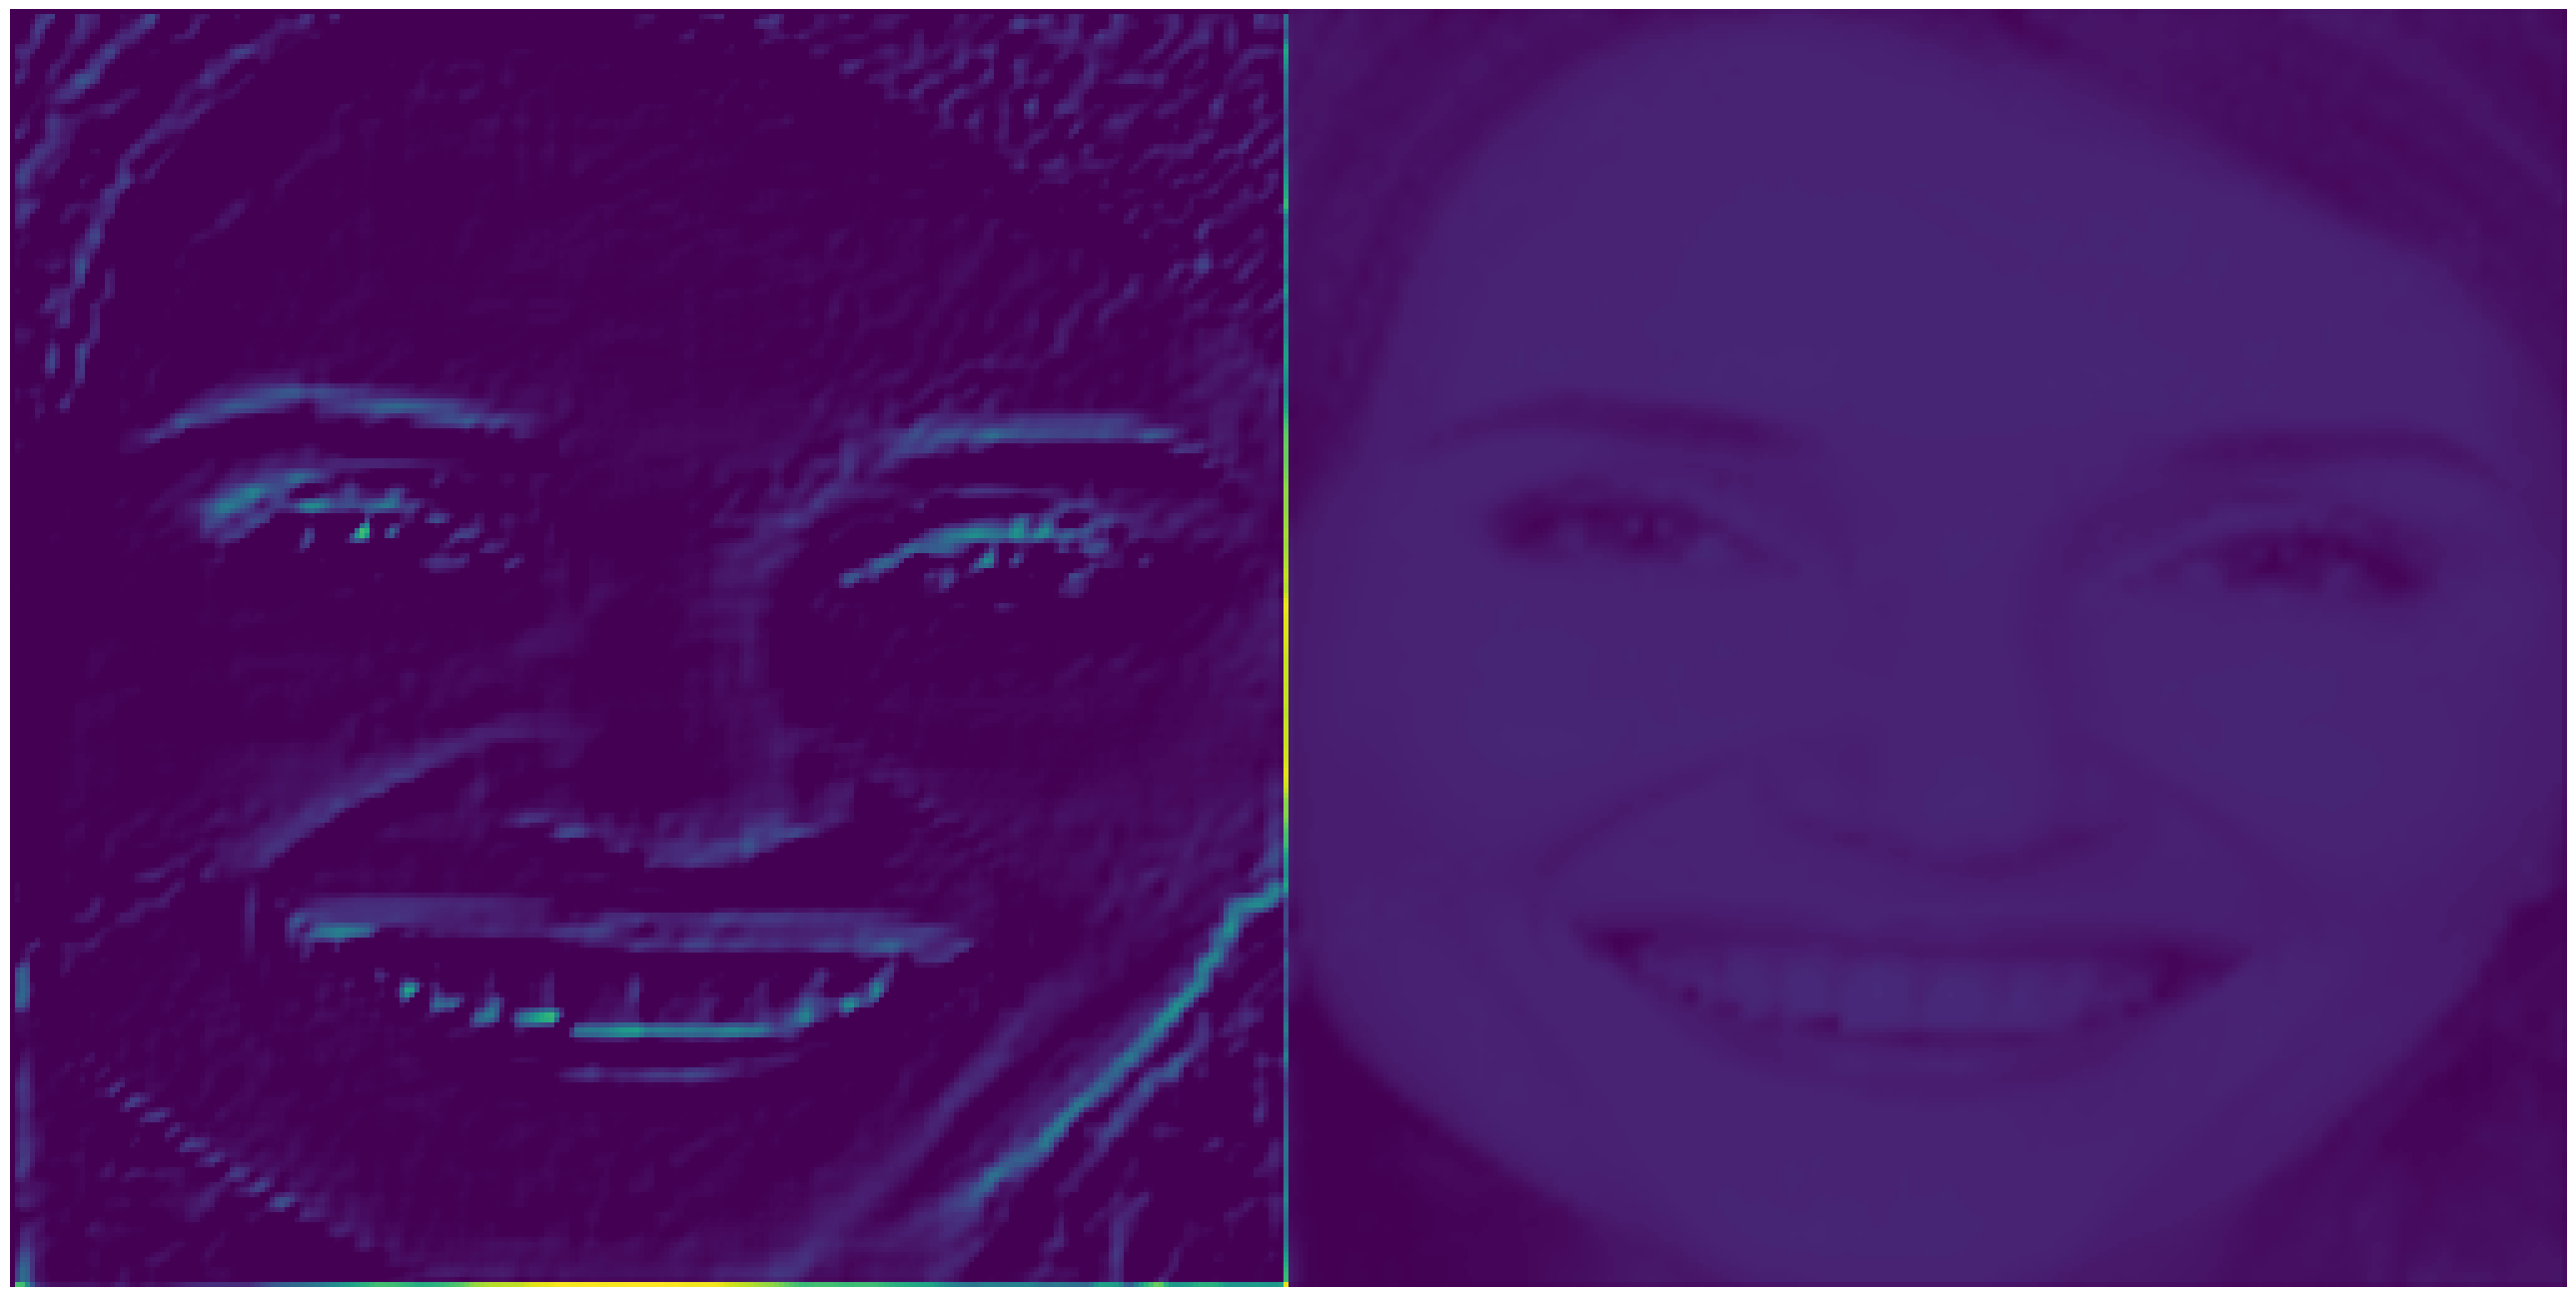

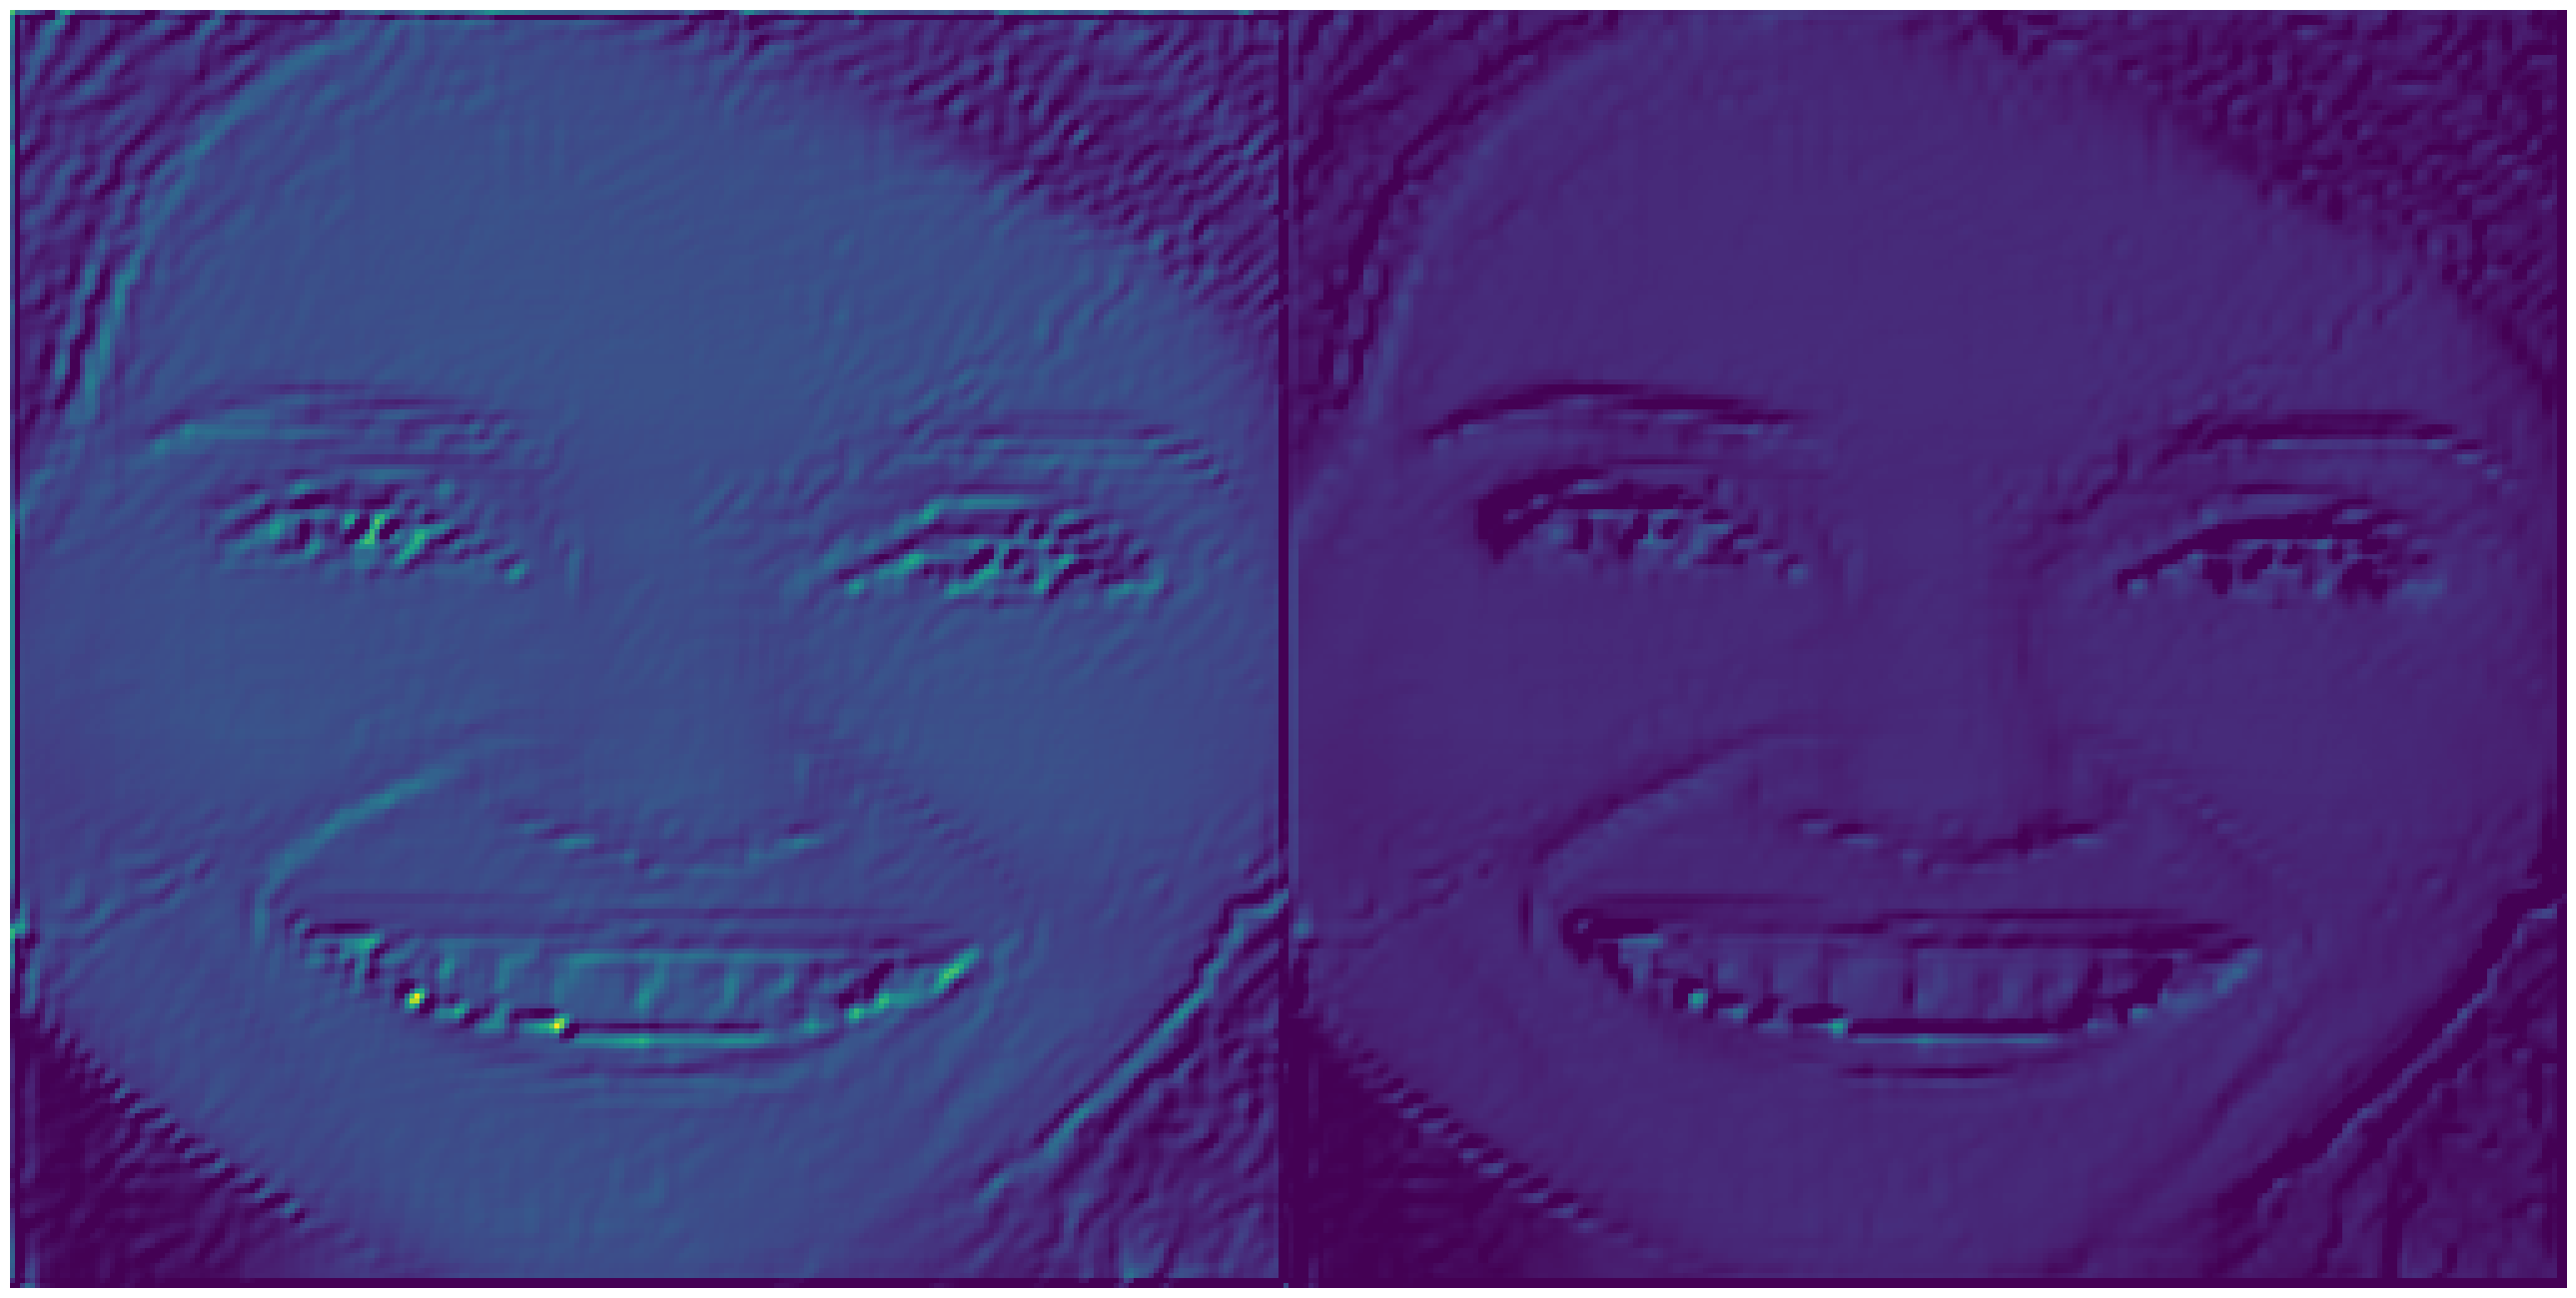

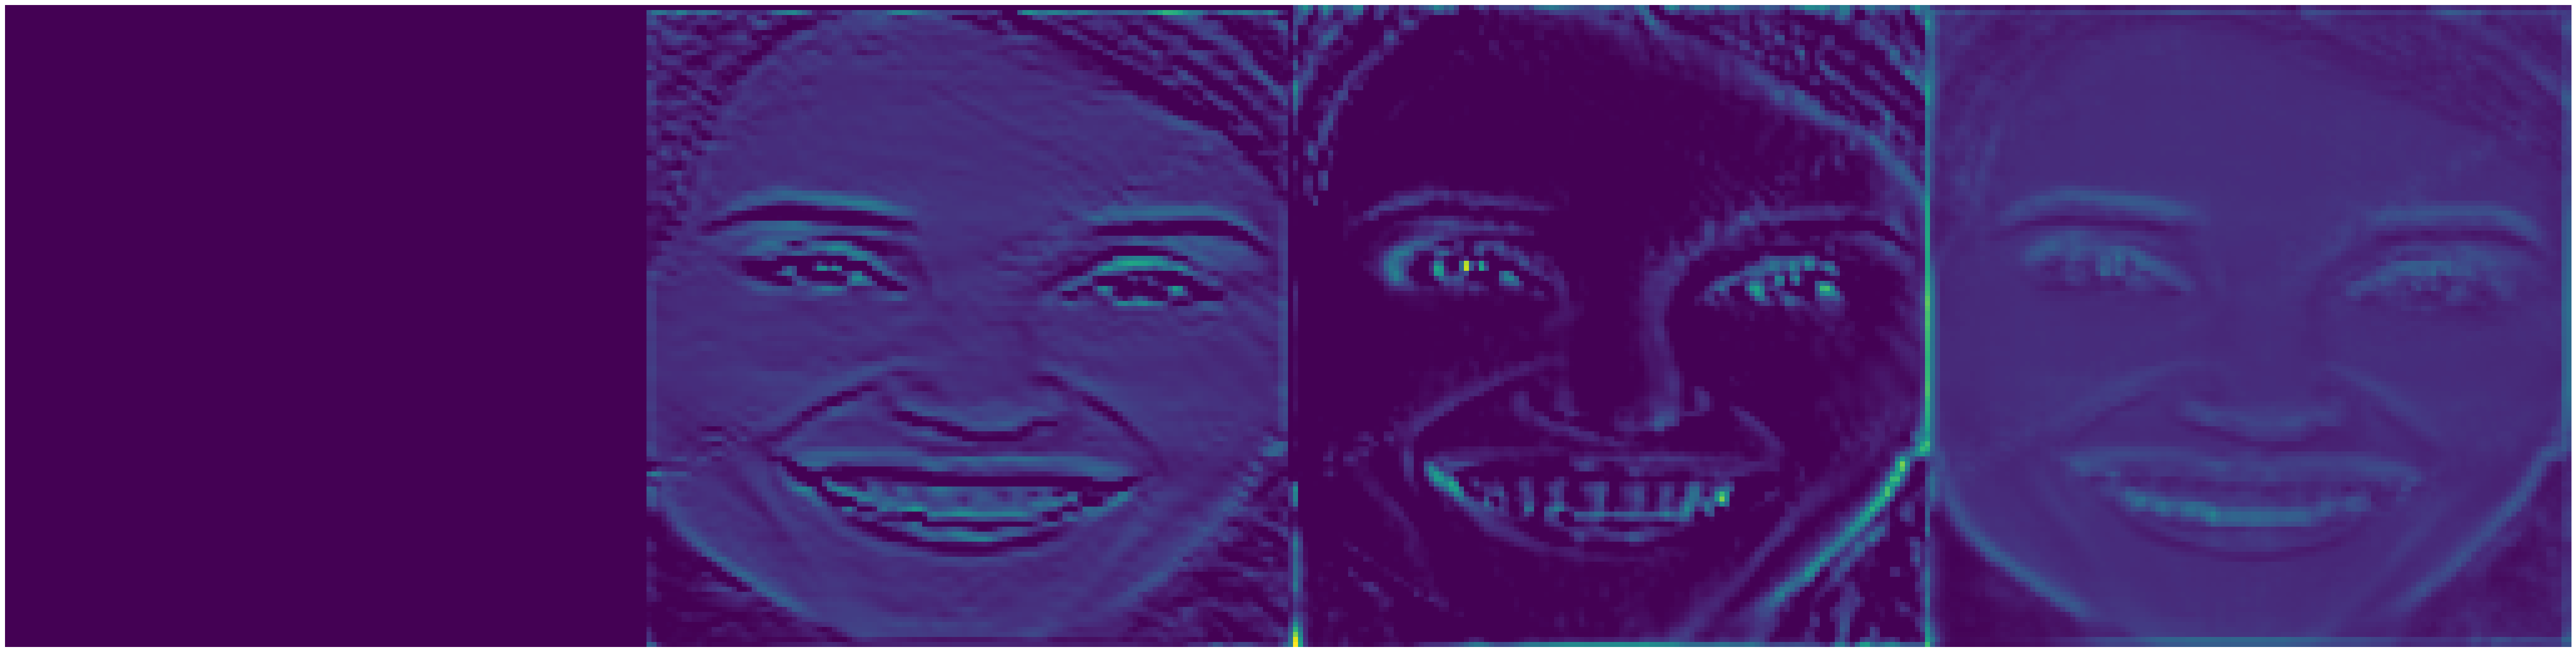

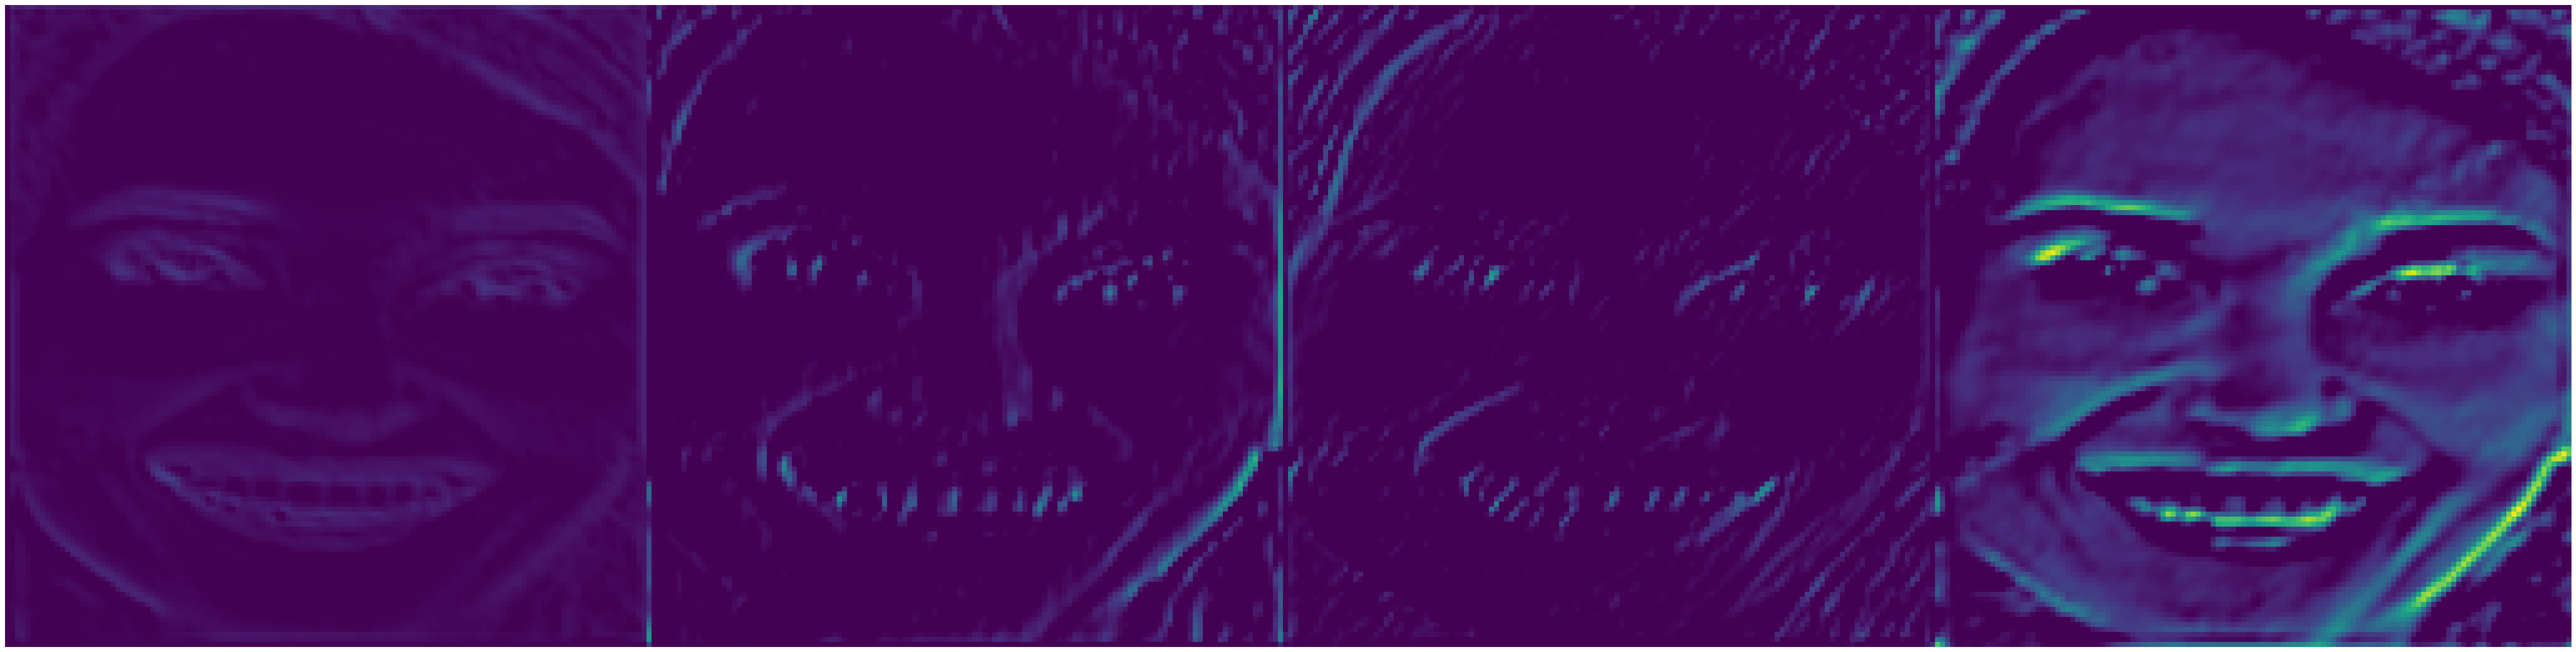

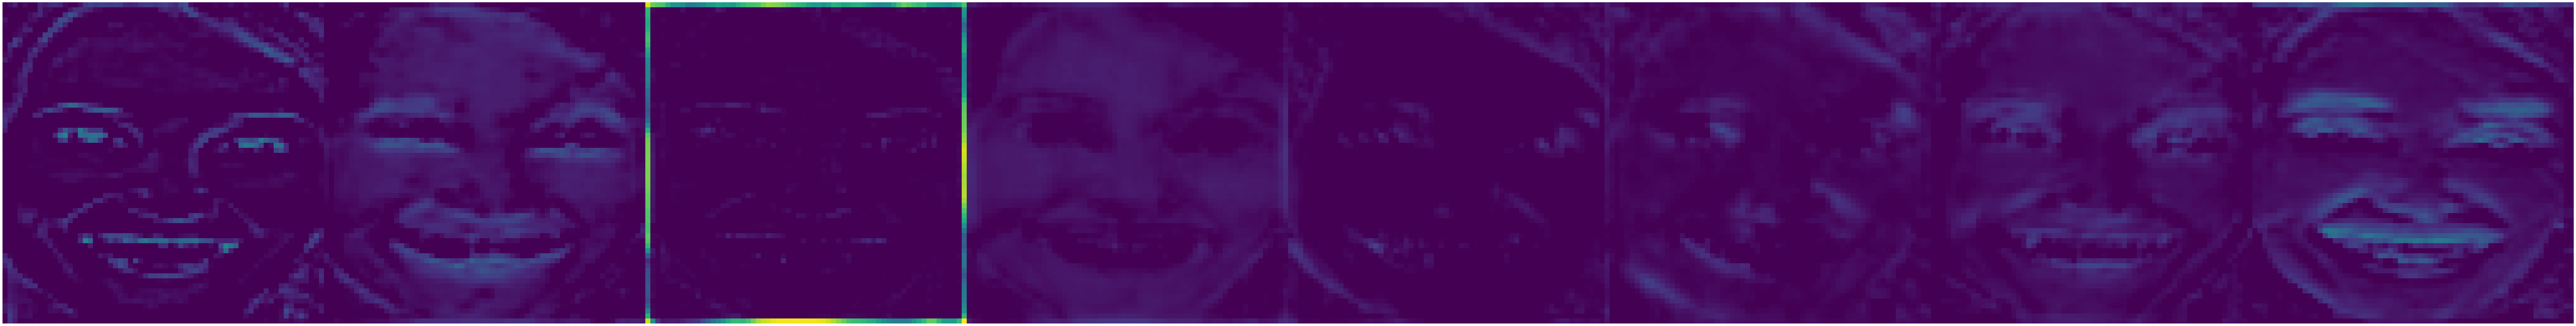

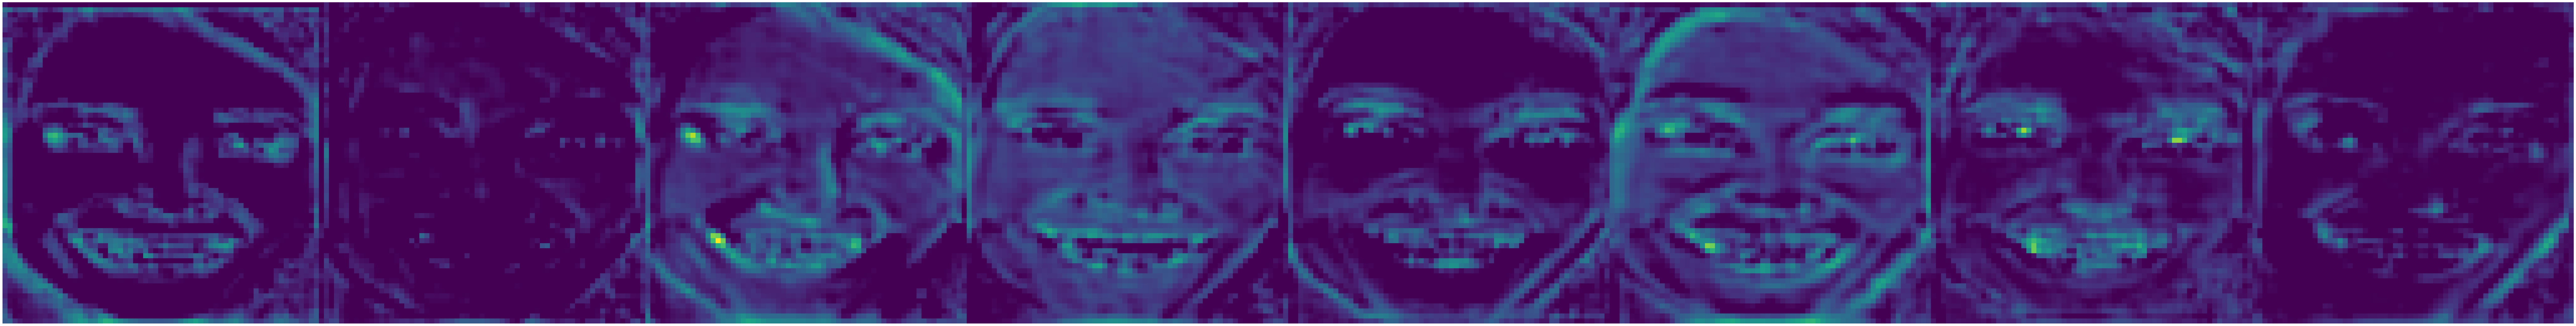

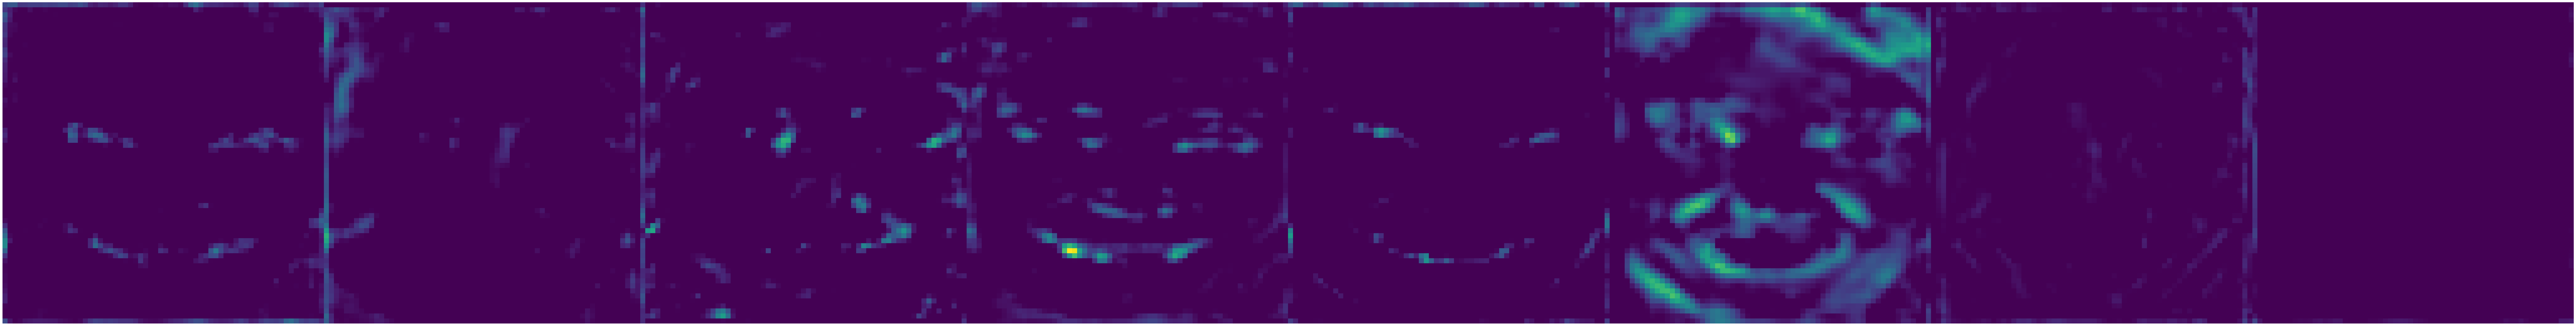

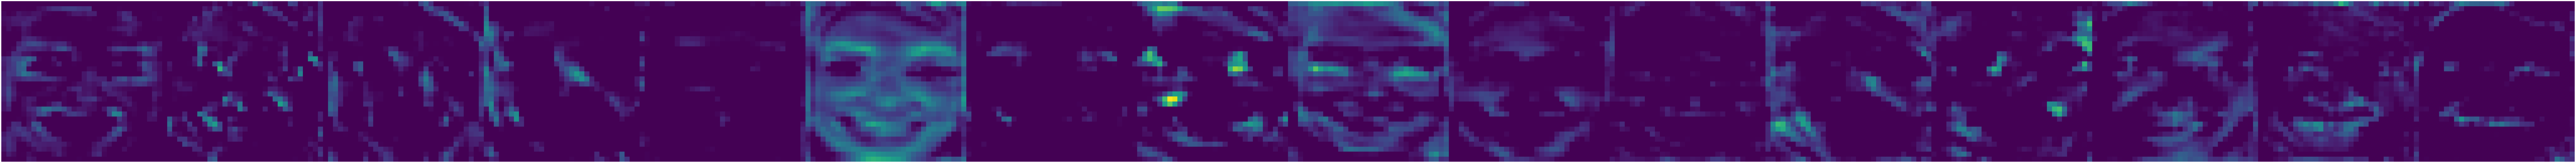

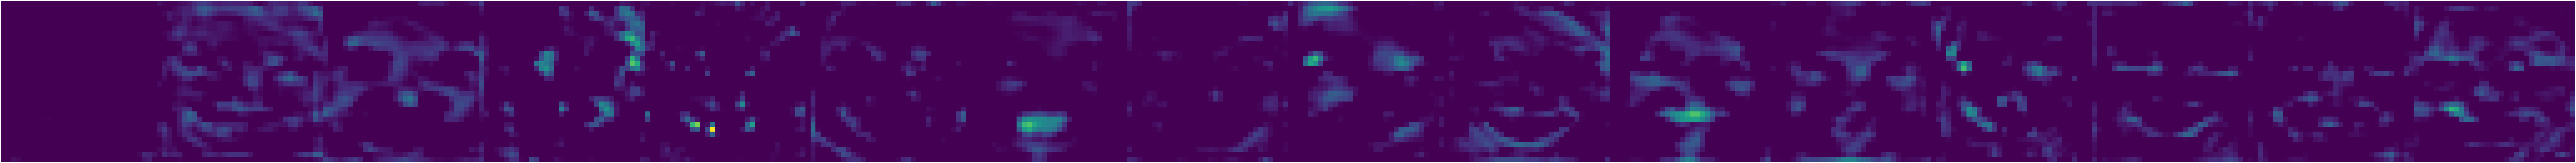

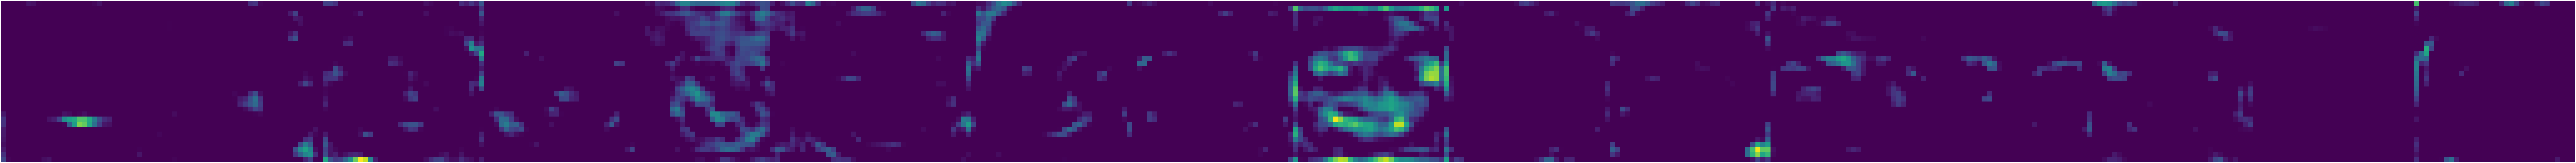

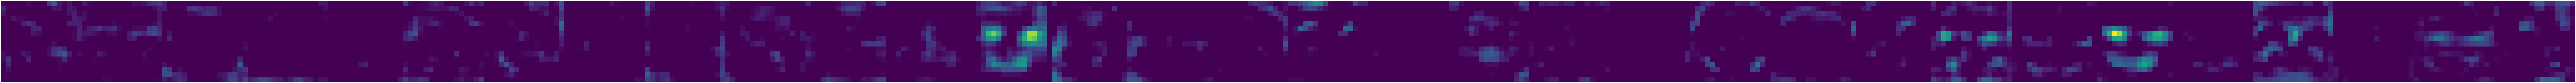

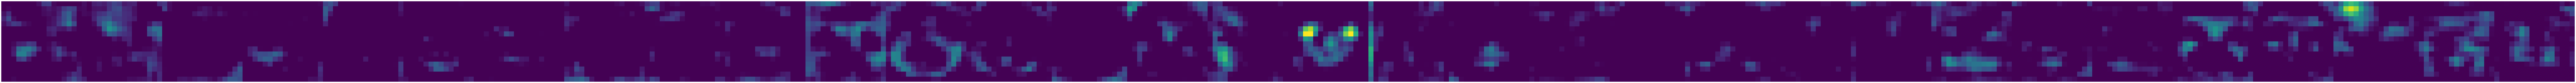

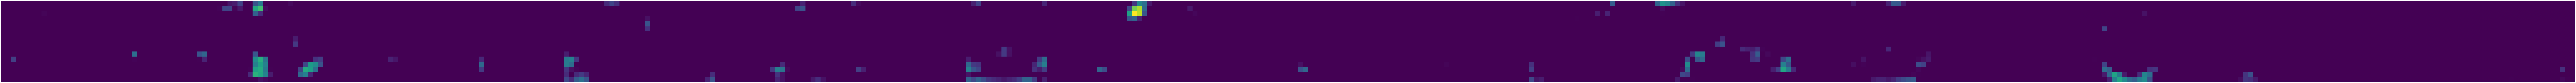

In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize=(256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_map = np.zeros((f_size , f_size * n_channels))

  axes= plt.subplot(len(f_maps) , 1 , i+1)
  for j in range(n_channels):
    joint_map[: , j * f_size : (j+1) * f_size] = f_maps[i][0 , : , : , j]

  plt.imshow(joint_map[:,0:512])
  plt.axis("off")




### Fine-tuning an EfficientNetB4 Model  

#### 1. **Loading the Pre-trained EfficientNetB4 Model**  
- **EfficientNetB4 Backbone**:  
  - `include_top=False`: Excludes the fully connected layers, making the model suitable for feature extraction.  
  - `weights='imagenet'`: Leverages pre-trained weights from the ImageNet dataset.  
  - `input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)`: Configures the input size to match the dataset.  
- **Freezing the Backbone**:  
  - `backbone.trainable = False`: Freezes the pre-trained weights to preserve their general-purpose feature extraction capability during the initial training phase.  

---

#### 2. **Defining the Model Architecture**  
- **Input Layer**:  
  - `Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))`: Specifies the input dimensions for the model.  

- **Feature Extraction**:  
  - The backbone processes the input to produce high-level feature maps, which are passed to subsequent layers for classification.  
  - `training=False`: Ensures the backbone remains in inference mode during initial training.  

- **Global Average Pooling**:  
  - `GlobalAveragePooling2D()`: Reduces the spatial dimensions of the feature maps into a single feature vector by computing the average of each channel.  

- **Dense Layers**:  
  - Two dense layers are added to introduce non-linear transformations:  
    - First layer: `Dense(CONFIGURATION["N_DENSE_1"], activation="relu")` for feature learning.  
    - Second layer: `Dense(CONFIGURATION["N_DENSE_2"], activation="relu")` for deeper representation.  
  - `BatchNormalization()`: Normalizes the intermediate outputs to stabilize and accelerate training.  

- **Output Layer**:  
  - `Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")`: Produces a probability distribution over the target classes using a softmax activation function.

---

#### 3. **Compiling the Model**  
- **Loss Function**:  
  - `CategoricalCrossentropy()`: Used for multi-class classification problems. It calculates the difference between the predicted and true class distributions.  

- **Metrics**:  
  - `CategoricalAccuracy`: Measures the proportion of correct predictions.  
  - `TopKCategoricalAccuracy(k=2)`: Tracks the accuracy when the true label is among the top 2 predictions.  

- **Optimizer**:  
  - `Adam(learning_rate=CONFIGURATION["LEARNING_RATE"])`: An adaptive optimizer for efficient training.  

---

#### 4. **Initial Training Phase**  
- **Training the Model**:  
  - The model is trained using `fit`, with frozen backbone weights.  
  - Datasets: `training_dataset` and `validation_dataset`.  
  - Epochs: `CONFIGURATION["N_EPOCHS"] * 3` ensures sufficient iterations for convergence.  

---

#### 5. **Unfreezing the Backbone**  
- After the initial training, the backbone is unfrozen:  
  - `backbone.trainable = True`: Allows the pre-trained layers to adapt to the new task.  
  - This fine-tuning improves the model's ability to learn task-specific features.  

- **Fine-tuning Compilation**:  
  - A smaller learning rate (`CONFIGURATION["LEARNING_RATE"] / 100`) is used to avoid large updates to the pre-trained weights.  

- **Fine-tuning Training**:  
  - The model is further trained with `epochs=100` and a checkpoint callback to save the best model during training.  

---

#### 6. **Model Summary**  
- **Trainable Parameters**:  
  - Initially, only the dense layers are trainable.  
  - After unfreezing, all parameters, including those in the backbone, are updated.  
  - The change in trainable parameters is visible in the updated model summary.  

This two-phase training strategy ensures the model leverages pre-trained knowledge effectively while adapting to the new task with fine-tuned weights.


In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy") , TopKCategoricalAccuracy(k=2 , name = "top_k_accuracy")]

In [ ]:
finetuned_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss = loss_function, metrics = metrics)

In [ ]:
history = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"]*3 , verbose = 1)

Epoch 1/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 94s 235ms/step - accuracy: 0.6289 - loss: 1.0714 - top_k_accuracy: 0.8716 - val_accuracy: 0.7353 - val_loss: 0.6159 - val_top_k_accuracy: 0.9192
Epoch 2/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7601 - loss: 0.5883 - top_k_accuracy: 0.9307 - val_accuracy: 0.7480 - val_loss: 0.5840 - val_top_k_accuracy: 0.9263
Epoch 3/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7962 - loss: 0.5060 - top_k_accuracy: 0.9483 - val_accuracy: 0.7739 - val_loss: 0.5624 - val_top_k_accuracy: 0.9324
Epoch 4/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8218 - loss: 0.4518 - top_k_accuracy: 0.9547 - val_accuracy: 0.7862 - val_loss: 0.5487 - val_top_k_accuracy: 0.9315
Epoch 5/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8386 - loss: 0.3985 - top_k_accuracy: 0.9625 - val_accuracy: 0.7603 - val_loss: 0.6182 - val_top_k_accuracy: 0.9241
Epoch 6/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8511 - loss: 0.3

In [ ]:
backbone.trainable = True

In [ ]:
finetuned_model.summary() # look now to the Trainable params

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,584,874 (89.97 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

 Optimizer params: 3,939,336 (15.03 MB)

In [ ]:
finetuned_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]/100), loss = loss_function, metrics = metrics) # make learning rate smaller

In [ ]:
# Checkpoint to save the model
model_dir = "/content/models/EfficientNetB4_finetuned"
os.makedirs(model_dir, exist_ok=True)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "EfficientNetB4_finetuned.keras"),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

In [ ]:
history_tuned = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = 100 , verbose = 1,callbacks=[checkpoint])

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 259s 572ms/step - accuracy: 0.6564 - loss: 3.7699 - top_k_accuracy: 0.8631 - val_accuracy: 0.6414 - val_loss: 2.7748 - val_top_k_accuracy: 0.8758
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.6247 - loss: 2.0843 - top_k_accuracy: 0.8691 - val_accuracy: 0.6115 - val_loss: 2.9504 - val_top_k_accuracy: 0.8565
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.6899 - loss: 1.4542 - top_k_accuracy: 0.9002 - val_accuracy: 0.6400 - val_loss: 2.3265 - val_top_k_accuracy: 0.8762
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.7369 - loss: 1.1167 - top_k_accuracy: 0.9265 - val_accuracy: 0.6953 - val_loss: 1.6022 - val_top_k_accuracy: 0.9030
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.7614 - loss: 0.8565 - top_k_accuracy: 0.9419 - val_accuracy: 0.7182 - val_loss: 1.3680 - val_top_k_accuracy: 0.9113
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.7

In [ ]:
evaluation_results = finetuned_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8606 - loss: 0.9696 - top_k_accuracy: 0.9553


This is a side note , not related to our job here but this is weird honestly , look:


In [ ]:
finetuned_model.save("/content/models/EfficientNetB4_finetuned/EfficientNetB4_finetuned.keras")

In [ ]:
from tensorflow.keras.models import load_model

# Path to the saved model
model_path = "/content/models/EfficientNetB4_finetuned/EfficientNetB4_finetuned.keras"

# Load the model
EfficientNetB4_finetuned = load_model(model_path)



In [ ]:
evaluation_results = EfficientNetB4_finetuned.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.3400 - loss: 120.1162 - top_k_accuracy: 0.7346


But when saving in .h5 format :

In [ ]:
finetuned_model.save("/content/models/EfficientNetB4_finetuned.h5")


In [ ]:
from tensorflow.keras.models import load_model

EfficientNetB4_finetuned = load_model("/content/models/EfficientNetB4_finetuned.h5")
evaluation_results = EfficientNetB4_finetuned.evaluate(validation_dataset)


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8565 - loss: 1.0785 - top_k_accuracy: 0.9513


### maybe `.h5` is Better than `.keras`  ?

The choice between saving models in `.h5` and `.keras` formats depends on compatibility and use cases:  

1. **Compatibility**:  
   - **`.h5`**:  
     - A widely supported format across various TensorFlow and Keras versions.  
     - Compatible with older TensorFlow versions and external frameworks, making it ideal for sharing models or using them in diverse environments.  
   - **`.keras`**:  
     - Introduced in TensorFlow 2.x, it integrates tightly with the modern Keras API but lacks backward compatibility.  

2. **Portability**:  
   - **`.h5`**:  
     - Can be used seamlessly in cross-platform scenarios or exported to other frameworks such as ONNX.  
     - Offers robust portability when moving models between different TensorFlow versions or setups.  

3. **Legacy Support**:  
   - Models saved in `.h5` format are supported by earlier versions of Keras and TensorFlow.  
   - This is particularly important when deploying models on systems that have not migrated to TensorFlow 2.x.  

4. **Interoperability**:  
   - **`.h5`** files are easier to load in other software that supports the HDF5 standard, enabling integrations with various data processing and machine learning tools.  

5. **Adoption**:  
   - Due to its long-standing presence, `.h5` is more familiar to many practitioners, ensuring easier adoption in collaborative projects.  

In summary, `.h5` is often preferred for its compatibility, portability, and interoperability, especially in diverse or legacy environments.


In [ ]:
import requests
def upload_to_github_release(repo_name, token, tag, file_path, release_name="Model Release"):
    """
    Pushes a file to a GitHub Release.
    Arguments:
        repo_name (str): Repository name in the format "username/repo".
        token (str): GitHub Fine-Grained Personal Access Token.
        tag (str): Release tag (e.g., "v1.0").
        file_path (str): Path to the file to upload.
        release_name (str): Name of the release.
    """
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/vnd.github+json",
    }
    # Step 1: Create a release
    release_url = f"https://api.github.com/repos/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/releases"
    release_data = {"tag_name": tag, "name": release_name, "draft": False, "prerelease": False}
    response = requests.post(release_url, headers=headers, json=release_data)
    if response.status_code != 201:
        print("Failed to create release:", response.json())
        return

    release_id = response.json()["id"]
    upload_url = response.json()["upload_url"].split("{")[0]

    # Step 2: Upload the file
    file_name = os.path.basename(file_path)
    with open(file_path, "rb") as f:
        upload_response = requests.post(
            f"{upload_url}?name={file_name}",
            headers=headers,
            files={"file": (file_name, f)},
        )
    if upload_response.status_code == 201:
        print("File successfully uploaded to GitHub Release!")
    else:
        print("Failed to upload file:", upload_response.json())

In [ ]:
model_path = "/content/models/EfficientNetB4_finetuned.h5"
github_repo = "Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision"  # Replace with your repo
github_token =  "" # Replace with your Fine-Grained Token
release_tag = "v6.0"  # Specify your release tag
upload_to_github_release(github_repo, github_token, release_tag, model_path , release_name = "Human Emotion Detection-EfficientNetB4_finetuned Model Release")


File successfully uploaded to GitHub Release!


In [ ]:
weights_file = "/content/models/EfficientNetB4_finetuned.weights.h5"
finetuned_model.save_weights(weights_file)

### Building the Model with EfficientNetB5 Backbone  

#### 1. **Using EfficientNetB5 as a Backbone**
- **Backbone Initialization**:
  - The EfficientNetB5 model is loaded as the base feature extractor using `tf.keras.applications.EfficientNetB5`.
  - Parameters:
    - `include_top=False`: Excludes the classification head, focusing only on feature extraction.
    - `weights='imagenet'`: Loads pre-trained weights from ImageNet, leveraging pre-trained knowledge for better performance on a smaller dataset.
    - `input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)`: Specifies the input shape of images.
  - **Freezing the Backbone**:
    - By setting `backbone.trainable=False`, the backbone layers are frozen during the initial training phase to preserve the pre-trained weights.

---

#### 2. **Adding Custom Layers**
- **Global Average Pooling**:
  - `GlobalAveragePooling2D()` replaces dense layers for spatial data aggregation. It reduces the feature map dimensions while retaining meaningful information.
  - This operation converts the 2D feature maps into a single vector per feature map.

- **Dense Layers**:
  - Two fully connected layers are added:
    - **First Dense Layer**:
      - Units: Defined by `CONFIGURATION["N_DENSE_1"]`.
      - Activation: `"relu"`, introducing non-linearity to the model.
    - **Second Dense Layer**:
      - Units: Defined by `CONFIGURATION["N_DENSE_2"]`.
      - Activation: `"relu"`, further transforming the feature representation.
  
- **Output Layer**:
  - The output layer has:
    - Units: `CONFIGURATION["NUM_CLASSES"]`, corresponding to the number of target classes.
    - Activation: `"softmax"`, producing class probabilities for multi-class classification.

---

#### 3. **Creating the Model**
- **Model Construction**:
  - The custom layers are combined with the backbone using the `Model` class.
  - Inputs: `backbone.inputs`, ensuring compatibility with the backbone.
  - Outputs: `output`, the final layer defining the classification task.
  
- **Summary**:
  - The `pretrained_model.summary()` provides an overview of the architecture, highlighting the number of layers, trainable parameters, and total parameters.  
  - This helps verify that the backbone layers are frozen and only the added layers are trainable.

---

#### 4. **Purpose of This Setup**
- Freezing the pre-trained backbone and adding custom layers allows the model to fine-tune efficiently on the new dataset while leveraging the robust feature extraction of EfficientNetB5.


In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This way of functional api definition , make the pretrained_model.summary() show more details about layers :

In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 256, 256, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 30,743,290 (117.28 MB)

 Trainable params: 2,229,763 (8.51 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy") , TopKCategoricalAccuracy(k=2 , name = "top_k_accuracy")]

In [ ]:
pretrained_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss = loss_function, metrics = metrics)

In [ ]:
history_pretrained_model = pretrained_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"]*2 , verbose = 1)

Epoch 1/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 112s 283ms/step - accuracy: 0.6453 - loss: 0.7615 - top_k_accuracy: 0.8760 - val_accuracy: 0.7586 - val_loss: 0.5681 - val_top_k_accuracy: 0.9236
Epoch 2/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7653 - loss: 0.5425 - top_k_accuracy: 0.9322 - val_accuracy: 0.7779 - val_loss: 0.5424 - val_top_k_accuracy: 0.9333
Epoch 3/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8011 - loss: 0.4618 - top_k_accuracy: 0.9548 - val_accuracy: 0.7932 - val_loss: 0.5148 - val_top_k_accuracy: 0.9399
Epoch 4/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8373 - loss: 0.3972 - top_k_accuracy: 0.9635 - val_accuracy: 0.7994 - val_loss: 0.5186 - val_top_k_accuracy: 0.9473
Epoch 5/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8558 - loss: 0.3561 - top_k_accuracy: 0.9698 - val_accuracy: 0.8130 - val_loss: 0.4658 - val_top_k_accuracy: 0.9456
Epoch 6/40
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8705 - los

# Explanation of Code for Visualizing Intermediate Layer and Grad-CAM with EfficientNetB5

### Loading and Preprocessing the Test Image
The first step involves reading and preparing the test image for use with the pre-trained EfficientNetB5 model:
1. `cv2.imread(img_path)` reads the image from the specified file path.
2. `cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))` resizes the image to match the required input dimensions of the model, as defined in `CONFIGURATION["IM_SIZE"]`.
3. `tf.constant(test_image, dtype=tf.float32)` converts the resized image into a TensorFlow tensor with data type `float32`.
4. `tf.expand_dims(im, axis=0)` adds an additional dimension to the tensor, converting it into a batch of size 1 (necessary for model input).
5. `print(img_array.shape)` prints the shape of the resulting tensor to verify its dimensions.

### Predicting the Class of the Image
1. `preds = pretrained_model.predict(img_array)` passes the processed image through the pre-trained EfficientNetB5 model to generate predictions.
2. `print(preds)` outputs the raw prediction values, which represent the likelihood of the image belonging to each class.
3. `np.argmax(preds[0])` retrieves the index of the class with the highest probability, indicating the predicted label for the image.

### Extracting the Last Convolutional Layer
1. `last_conv_layer_name = "top_activation"` specifies the name of the last convolutional layer of the EfficientNetB5 model. This layer's activations are critical for generating Grad-CAM visualizations.
2. `last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)` retrieves the specified layer from the pre-trained model.
3. `last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)` creates a new model that outputs the activations of the last convolutional layer when provided with the same inputs as the original model.

### Building the Classifier Model
1. `classifier_layer_names` defines a list of layer names that make up the classification head of the EfficientNetB5 model.
2. `classifier_input = Input(shape=(8,8,2048))` creates an input tensor that matches the output shape of the last convolutional layer.
3. A loop iterates through `classifier_layer_names`, applying each layer sequentially to the `classifier_input` tensor. This reconstructs the classification head of the model.
4. `classifier_model = Model(classifier_input, x)` creates a new model that represents the classifier portion of the EfficientNetB5 architecture.

### Computing Gradients with GradientTape
1. `with tf.GradientTape() as tape:` initiates TensorFlow's gradient-tracking mechanism, allowing gradients to be calculated with respect to specific inputs.
2. `last_conv_layer_output = last_conv_layer_model(img_array)` passes the image through the model to obtain activations from the last convolutional layer.
3. `preds = classifier_model(last_conv_layer_output)` passes the activations through the classifier model to generate predictions.
4. `top_pred_index = tf.argmax(preds[0])` identifies the index of the class with the highest prediction score.
5. `top_class_channel = preds[:, top_pred_index]` isolates the score corresponding to the predicted class.
6. `grads = tape.gradient(top_class_channel, last_conv_layer_output)` calculates the gradient of the predicted class score with respect to the activations of the last convolutional layer, which forms the basis of Grad-CAM.

By following these steps, the code enables visualization of the intermediate layers and preparation for generating Grad-CAM heatmaps, which highlight the regions of the input image that contribute most to the model's predictions.


In [ ]:
img_path = "/content/4/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

(1, 256, 256, 3)


In [ ]:
preds = pretrained_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
print(preds)

[[2.5173487e-05 9.9997485e-01 1.9852298e-09]]


In [ ]:
np.argmax(preds[0])

1

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
last_conv_layer_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 256, 256, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,513,527 (108.77 MB)

In [ ]:
for layer in pretrained_model.layers:
    print(layer.name)

input_layer_2
rescaling_2
normalization_1
rescaling_3
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block1c_dwconv
block1c_bn
block1c_activation
block1c_se_squeeze
block1c_se_reshape
block1c_se_reduce
block1c_se_expand
block1c_se_excite
block1c_project_conv
block1c_project_bn
block1c_drop
block1c_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_acti

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d_1",
 "dense_3",
 "dense_4",
 "dense_5"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(1, shape=(), dtype=int64)


### Visualizing Grad-CAM Heatmap

#### Gradients Shape and Pooling
1. `grads.shape` prints the shape of the gradient tensor, which represents the gradient of the predicted class with respect to each channel in the last convolutional layer's output.
2. `pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()` computes the average gradient for each channel across the spatial dimensions (height and width), reducing the tensor to a 1D array of size equal to the number of channels. These pooled gradients indicate the importance of each feature map.
3. `print(pooled_grads.shape)` confirms the shape of the pooled gradients, which should match the number of channels in the convolutional layer (e.g., 2048 for EfficientNetB5).

#### Modifying the Last Convolutional Layer's Output
1. `last_conv_layer_output.shape` displays the shape of the last convolutional layer's activations before further processing.
2. `last_conv_layer_output = last_conv_layer_output.numpy()[0]` extracts the activations as a NumPy array and removes the batch dimension.
3. The loop `for i in range(2048): last_conv_layer_output[:, :, i] *= pooled_grads[i]` weights each feature map by its corresponding pooled gradient. This step highlights the importance of each feature map based on the class prediction.

#### Generating the Heatmap
1. `heatmap = np.sum(last_conv_layer_output, axis=-1)` sums the weighted feature maps across all channels to produce a 2D heatmap that highlights regions contributing to the prediction.
2. `heatmap=tf.nn.relu(heatmap)` applies the ReLU activation to ensure the heatmap contains only positive values, focusing on regions that positively impact the prediction.
3. `plt.matshow(heatmap)` displays the raw heatmap using a simple visualization.

#### Resizing and Overlaying the Heatmap
1. `resized_heatmap = cv2.resize(np.array(heatmap), (256, 256))` resizes the heatmap to match the input image dimensions for visualization purposes.
2. `plt.matshow(resized_heatmap * 255)` visualizes the resized heatmap, scaled to enhance contrast.

#### Overlaying the Heatmap on the Input Image
1. `plt.imshow(img_array[0,:,:,0]/255, alpha=0.8)` displays the original image as a grayscale image normalized to [0,1].
2. `plt.imshow(resized_heatmap, cmap='jet', alpha=0.5)` overlays the Grad-CAM heatmap onto the original image using a color map (e.g., `jet`) to highlight the regions most responsible for the model's prediction. The `alpha` parameter controls the transparency of the heatmap.
3. By layering these visualizations, the combined plot provides an intuitive understanding of how the model focuses on specific image regions.

This visualization process completes the Grad-CAM implementation, illustrating the areas of the image that the model considers most relevant for its predictions.
### Visualizing Grad-CAM Heatmap

#### Gradients Shape and Pooling
1. `grads.shape` prints the shape of the gradient tensor, which represents the gradient of the predicted class with respect to each channel in the last convolutional layer's output.
2. `pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()` computes the average gradient for each channel across the spatial dimensions (height and width), reducing the tensor to a 1D array of size equal to the number of channels. These pooled gradients indicate the importance of each feature map.
3. `print(pooled_grads.shape)` confirms the shape of the pooled gradients, which should match the number of channels in the convolutional layer (e.g., 2048 for EfficientNetB5).

#### Modifying the Last Convolutional Layer's Output
1. `last_conv_layer_output.shape` displays the shape of the last convolutional layer's activations before further processing.
2. `last_conv_layer_output = last_conv_layer_output.numpy()[0]` extracts the activations as a NumPy array and removes the batch dimension.
3. The loop `for i in range(2048): last_conv_layer_output[:, :, i] *= pooled_grads[i]` weights each feature map by its corresponding pooled gradient. This step highlights the importance of each feature map based on the class prediction.

#### Generating the Heatmap
1. `heatmap = np.sum(last_conv_layer_output, axis=-1)` sums the weighted feature maps across all channels to produce a 2D heatmap that highlights regions contributing to the prediction.
2. `heatmap=tf.nn.relu(heatmap)` applies the ReLU activation to ensure the heatmap contains only positive values, focusing on regions that positively impact the prediction.
3. `plt.matshow(heatmap)` displays the raw heatmap using a simple visualization.

#### Resizing and Overlaying the Heatmap
1. `resized_heatmap = cv2.resize(np.array(heatmap), (256, 256))` resizes the heatmap to match the input image dimensions for visualization purposes.
2. `plt.matshow(resized_heatmap * 255)` visualizes the resized heatmap, scaled to enhance contrast.

#### Overlaying the Heatmap on the Input Image
1. `plt.imshow(img_array[0,:,:,0]/255, alpha=0.8)` displays the original image as a grayscale image normalized to [0,1].
2. `plt.imshow(resized_heatmap, cmap='jet', alpha=0.5)` overlays the Grad-CAM heatmap onto the original image using a color map (e.g., `jet`) to highlight the regions most responsible for the model's prediction. The `alpha` parameter controls the transparency of the heatmap.
3. By layering these visualizations, the combined plot provides an intuitive understanding of how the model focuses on specific image regions.

This visualization process completes the Grad-CAM implementation, illustrating the areas of the image that the model considers most relevant for its predictions.


In [ ]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pooled_grads.shape)

(2048,)


In [ ]:
last_conv_layer_output.shape

TensorShape([1, 8, 8, 2048])

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

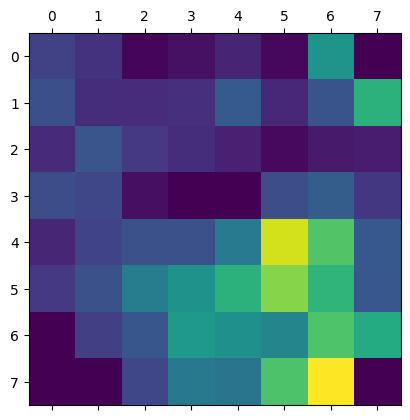

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

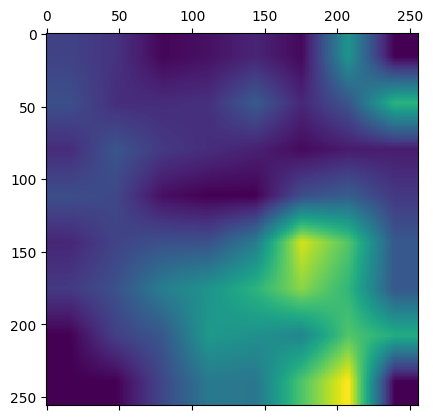

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255)

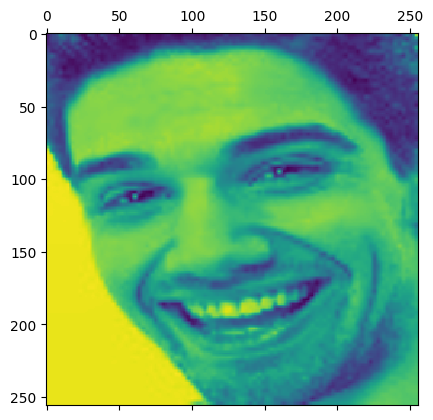

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)

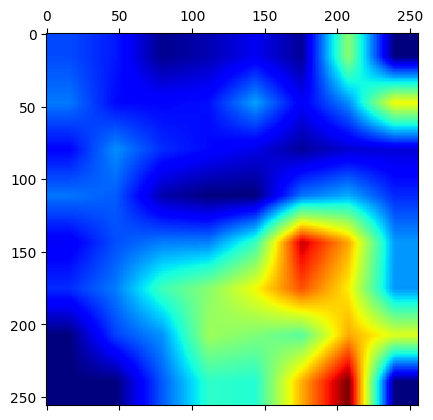

In [ ]:
plt.matshow(resized_heatmap, cmap='jet')


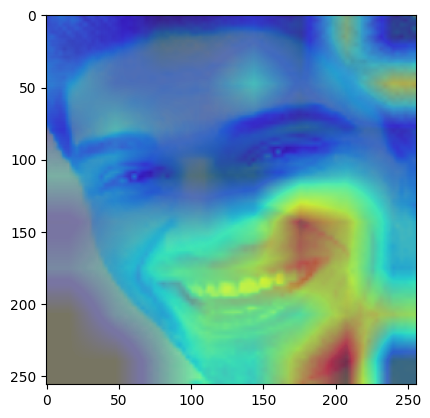

In [ ]:
plt.imshow(img_array[0,:,:,0]/255, alpha=0.8)  # Original image
plt.imshow(resized_heatmap, cmap='jet', alpha=0.5)  # Grad-CAM heatmap
